In [1]:
%load_ext autoreload
%matplotlib inline

# Anomaly Detection Evaluation

In [2]:
import os, sys
import numpy as np
import pandas as pd
from IPython.display import display
sys.path.append(os.path.abspath(os.path.join('..')))

import plot.anomalies
from database.CERNMongoClient import CERNMongoClient
from anomaly_detection import GMM
from evaluation import evaluation, segmentation
from feature_extraction import feature_extraction, preprocessing

db = CERNMongoClient()

# auto-load changes in imported modules
%autoreload 2

In [3]:
# B1, 30min
B1_30 = feature_extraction.load_features_from_file("features_b1_sw-30min*")
B1_30_s = preprocessing.scale_robust(B1_30)

# B2, 30min
B2_30 = feature_extraction.load_features_from_file("features_b2_sw-30min*")
B2_30_s = preprocessing.scale_robust(B2_30)

labels = db.query_elogbook_anomalies()

Loading file '/home/n/master-thesis/src/../data-cern/features_b1_sw-30min*'.
File not found, loading '/home/n/master-thesis/src/../data-cern/features_b1_sw-30min_2018-02-26.csv' instead.
Loading file '/home/n/master-thesis/src/../data-cern/features_b2_sw-30min*'.
File not found, loading '/home/n/master-thesis/src/../data-cern/features_b2_sw-30min_2018-02-26.csv' instead.
Fetching data for pattern MKI.ELOGBOOK_tagged from 2016-04-16 00:00:00.000000 to 2016-09-14 00:00:00.000000
Fetching data for MKI.ELOGBOOK_tagged


## Prediction

In [4]:
clf_B1 = GMM.GMM(n_components=6, covariance_type='tied')
B1_scored = clf_B1.fit_and_append_scores(B1_30_s)

clf_B2 = GMM.GMM(n_components=6, covariance_type='tied')
B2_scored = clf_B2.fit_and_append_scores(B2_30_s)

## Evaluation

### Segmentation

In [5]:
segment_sizes = [200, 250, 500, 750, 1000]
segments_lists_B1 = list(segmentation.generate_multiple_segments(B1_scored, segment_sizes))
segments_lists_B2 = list(segmentation.generate_multiple_segments(B2_scored, segment_sizes))

In [6]:
segmentation.print_segment_stats(segments_lists_B1[-1], segments_lists_B2[-1])

B1: Number of segments:  111
B1: Min segment length:  0 days 00:00:00
B1: Mean segment length: 0 days 04:21:33.243243
B1: Max segment length:  0 days 17:24:18
B1: Check: anomalies:    871

B2: Number of segments:  121
B2: Min segment length:  0 days 00:00:00
B2: Mean segment length: 0 days 05:21:04.859504
B2: Max segment length:  0 days 17:39:36
B1: Check: anomalies:    932


In [8]:
for i, size in enumerate(segment_sizes):
    table = evaluation.labels_vs_segments_beams(labels, segments_lists_B1[i], segments_lists_B2[i])
    
    display(evaluation.apply_style_labels_vs_beams(table))
    evaluation.print_labels_vs_segments_stats(size, segments_lists_B1[i], segments_lists_B2[i], table)

Anomalies used: 200
Anomalies in segments for B1: 200
Anomalies in segments for B2: 200
Segments in B1: 78
Segments in B2: 83
Segments for B1 that lie near anomaly labels:  6.0
Segments for B2 that lie near anomaly labels:  8.0
Anomalies in segments for B1 that lie near anomaly labels:  11.0
Anomalies in segments for B2 that lie near anomaly labels:  23.0


Anomalies used: 250
Anomalies in segments for B1: 250
Anomalies in segments for B2: 249
Segments in B1: 83
Segments in B2: 90
Segments for B1 that lie near anomaly labels:  7.0
Segments for B2 that lie near anomaly labels:  8.0
Anomalies in segments for B1 that lie near anomaly labels:  17.0
Anomalies in segments for B2 that lie near anomaly labels:  26.0


Anomalies used: 500
Anomalies in segments for B1: 468
Anomalies in segments for B2: 495
Segments in B1: 95
Segments in B2: 114
Segments for B1 that lie near anomaly labels:  12.0
Segments for B2 that lie near anomaly labels:  10.0
Anomalies in segments for B1 that lie near anomaly labels:  126.0
Anomalies in segments for B2 that lie near anomaly labels:  46.0


Anomalies used: 750
Anomalies in segments for B1: 665
Anomalies in segments for B2: 721
Segments in B1: 105
Segments in B2: 118
Segments for B1 that lie near anomaly labels:  12.0
Segments for B2 that lie near anomaly labels:  10.0
Anomalies in segments for B1 that lie near anomaly labels:  192.0
Anomalies in segments for B2 that lie near anomaly labels:  168.0


Anomalies used: 1000
Anomalies in segments for B1: 871
Anomalies in segments for B2: 932
Segments in B1: 111
Segments in B2: 121
Segments for B1 that lie near anomaly labels:  12.0
Segments for B2 that lie near anomaly labels:  13.0
Anomalies in segments for B1 that lie near anomaly labels:  313.0
Anomalies in segments for B2 that lie near anomaly labels:  225.0


Change since last time: segments can still expand in next step if total size of the segment is under 12 hours
* score is the mean score of all anomalies in the segments
* lower score = more anomalous
* small segments don't increase much over time
* not many anomalies discarded 
* number of segments doubles while number of points * 5

### Visualization

Next figures show some visualizations of the detected anomalies on beam 1 & 2. A taller bar is more likely to be an anomaly. This should not be done as a log plot since the extracted anomalies are already log probabilities.

Fetching data for pattern MKI.ELOGBOOK_tagged from 2016-04-16 00:00:00.000000 to 2016-09-14 00:00:00.000000
Fetching data for MKI.ELOGBOOK_tagged
Fetching data for pattern MKI.ELOGBOOK_tagged from 2016-04-16 00:00:00.000000 to 2016-09-14 00:00:00.000000
Fetching data for MKI.ELOGBOOK_tagged


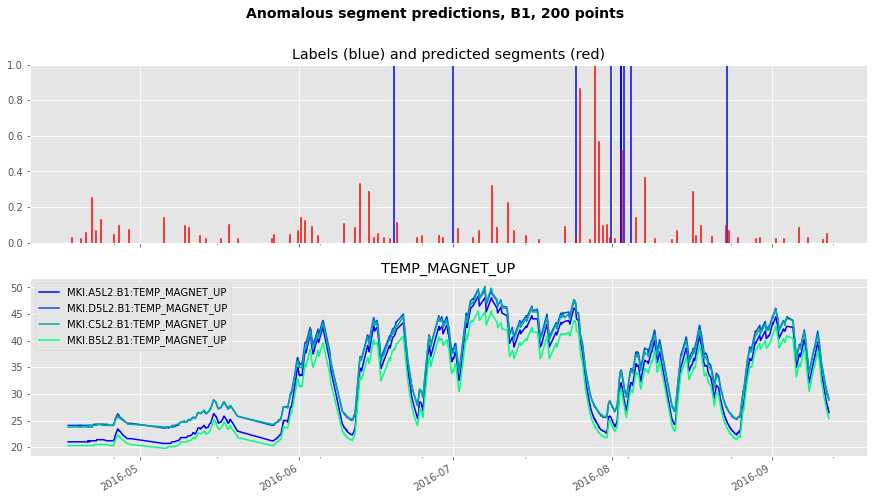

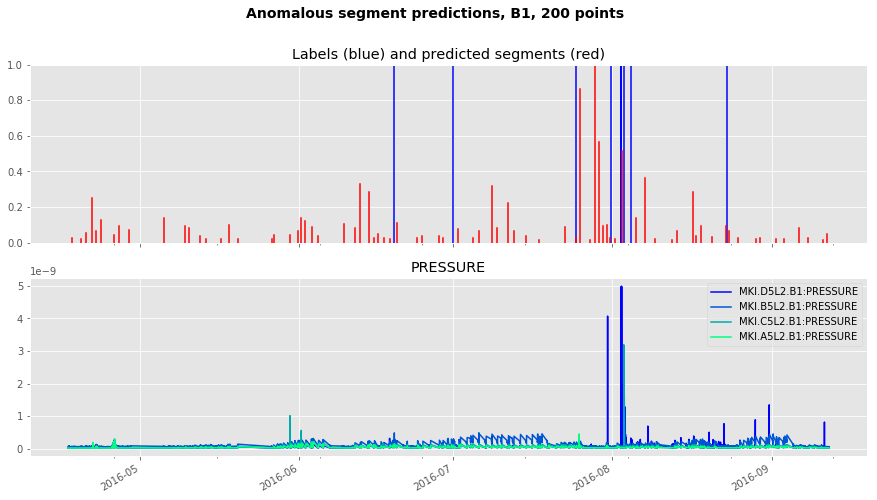

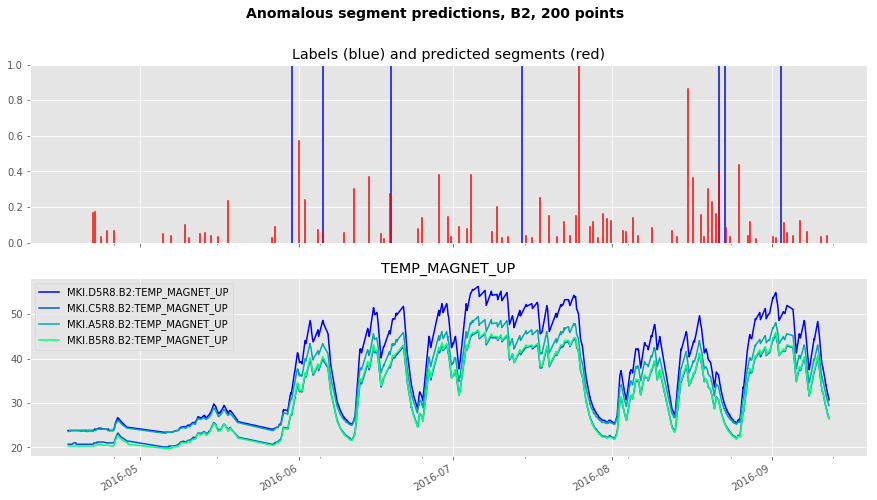

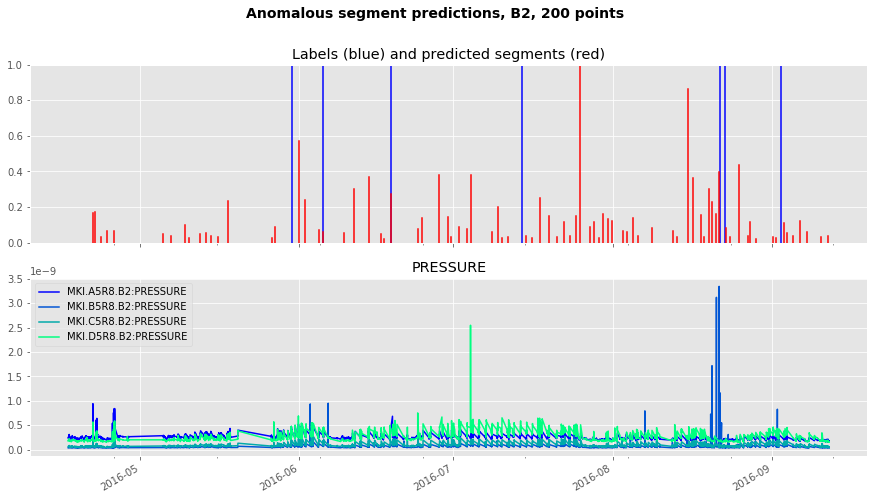

In [9]:
labels_B1 = db.query_elogbook_anomalies(beam=1)
labels_B2 = db.query_elogbook_anomalies(beam=2)

plot.anomalies.timeseries_segments(B1_30, "TEMP_MAGNET_UP", segments_lists_B1[0], labels_B1, 'Anomalous segment predictions, B1, 200 points')
plot.anomalies.timeseries_segments(B1_30, "PRESSURE", segments_lists_B1[0], labels_B1, 'Anomalous segment predictions, B1, 200 points')

plot.anomalies.timeseries_segments(B2_30, "TEMP_MAGNET_UP", segments_lists_B2[0], labels_B2, 'Anomalous segment predictions, B2, 200 points')
plot.anomalies.timeseries_segments(B2_30, "PRESSURE", segments_lists_B2[0], labels_B2, 'Anomalous segment predictions, B2, 200 points')

Now with all labels in the logbook (except info labels):

Fetching data for pattern MKI.ELOGBOOK_tagged from 2016-04-16 00:00:00.000000 to 2016-09-14 00:00:00.000000
Fetching data for MKI.ELOGBOOK_tagged
Fetching data for pattern MKI.ELOGBOOK_tagged from 2016-04-16 00:00:00.000000 to 2016-09-14 00:00:00.000000
Fetching data for MKI.ELOGBOOK_tagged


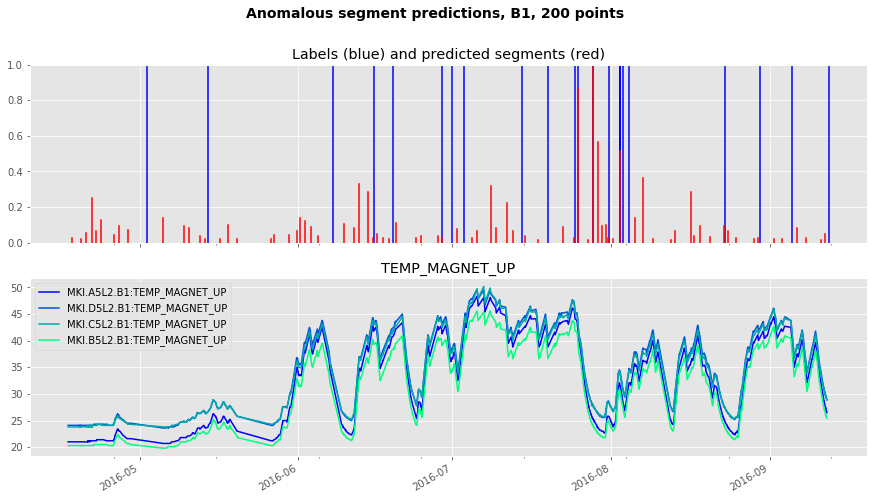

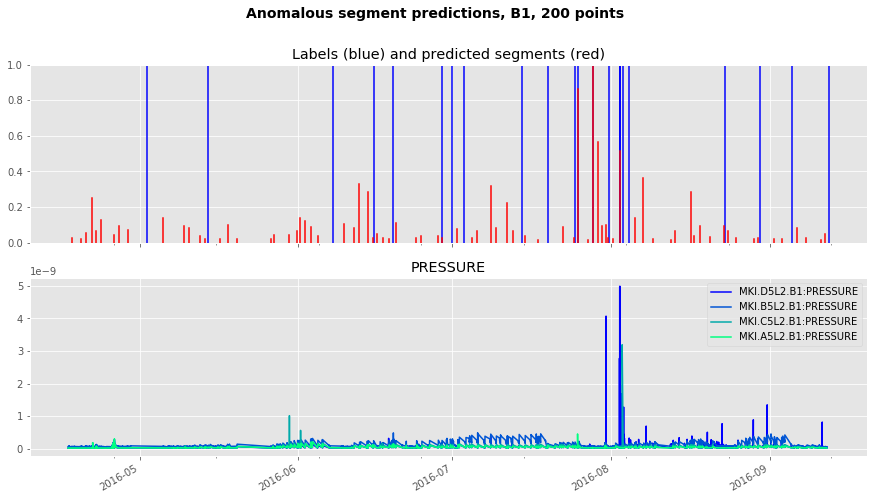

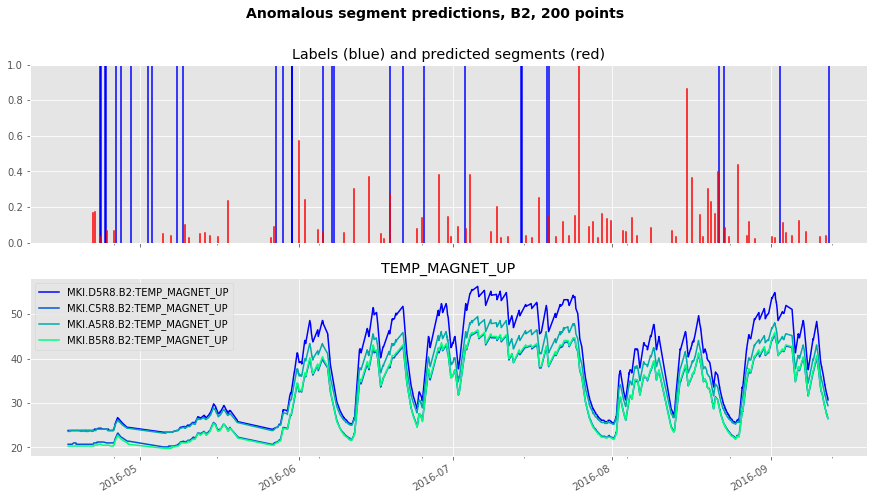

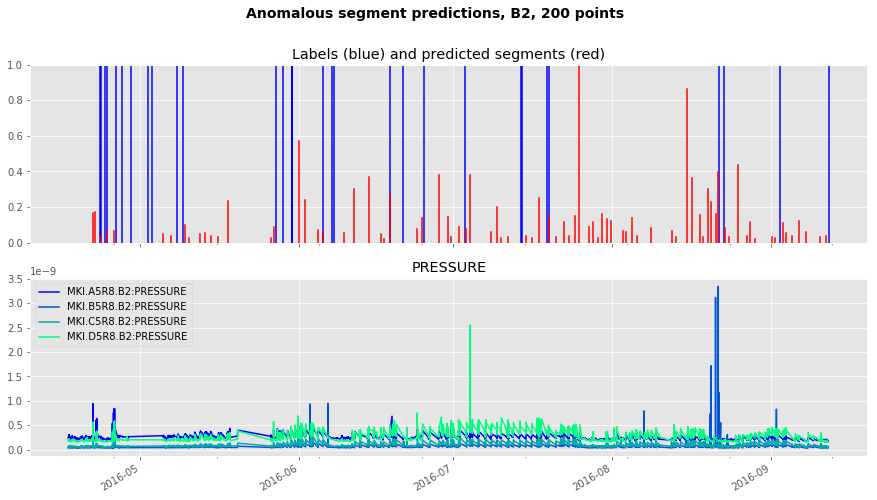

In [10]:
labels_B1_all = db.query_elogbook_no_info(beam=1)
labels_B2_all = db.query_elogbook_no_info(beam=2)

plot.anomalies.timeseries_segments(B1_30, "TEMP_MAGNET_UP", segments_lists_B1[0], labels_B1_all, 'Anomalous segment predictions, B1, 200 points')
plot.anomalies.timeseries_segments(B1_30, "PRESSURE", segments_lists_B1[0], labels_B1_all, 'Anomalous segment predictions, B1, 200 points')

plot.anomalies.timeseries_segments(B2_30, "TEMP_MAGNET_UP", segments_lists_B2[0], labels_B2_all, 'Anomalous segment predictions, B2, 200 points')
plot.anomalies.timeseries_segments(B2_30, "PRESSURE", segments_lists_B2[0], labels_B2_all, 'Anomalous segment predictions, B2, 200 points')

## Supervised learning on beam 1

### Label the data

In [11]:
B1_30_s_supervised = B1_30_s.copy()
B1_30_s_supervised['anomaly'] = 0
for anom_ts in labels_B1.index:
    start_of_segment = anom_ts - pd.Timedelta(12, unit='h')
    B1_30_s_supervised.loc[start_of_segment:anom_ts, 'anomaly'] = 1

In [12]:
from sklearn.ensemble import RandomForestClassifier
training = B1_30_s_supervised.loc[:'2016-08-03 18:00:00']
test = B1_30_s_supervised.loc['2016-08-03 18:00:00': ]
display('Training set size: {}'.format(training.shape[0])) 
display('Test set size: {}'.format(test.shape[0]))
display('Labels in training: {}'.format(labels_B1.loc[:'2016-08-03 18:00:00'].shape[0]))
display('Labels in test: {}'.format(labels_B1.loc['2016-08-03 18:00:00':].shape[0]))

train_features = training.ix[:, ~B1_30_s_supervised.columns.isin(['score', 'anomaly'])]
train_labels = training['anomaly']
test_features = test.ix[:, ~B1_30_s_supervised.columns.isin(['score', 'anomaly'])]
test_labels = test['anomaly']

'Training set size: 32249'

'Test set size: 13841'

'Labels in training: 7'

'Labels in test: 2'

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  # This is added back by InteractiveShellApp.init_path()


### Predict

In [13]:
clf = RandomForestClassifier(class_weight='balanced').fit(train_features, train_labels)
# negation here because the classifier will return 1 for anomalous
predictions = -clf.predict(test_features)
# predictions = -clf.predict_proba(test_features) 
predictions.sum()

-258

In [14]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
display(precision_recall_fscore_support(test_labels, predictions))
display(confusion_matrix(test_labels, predictions, labels=[1, 0]))

/home/n/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/n/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


(array([0.        , 0.95899286, 0.        ]),
 array([0.        , 0.98846562, 0.        ]),
 array([0.        , 0.97350622, 0.        ]),
 array([    0, 13178,   663]))

array([[    0,   557],
       [    0, 13026]])

In [16]:
test_features = test_features.copy()
test_features['score'] = predictions
detected = test_features[test_features['score'] != 0].copy()
detected_w_label, labeled_w_detected = evaluation.labels_vs_predictions(labels_B1, detected)
display(labeled_w_detected)

points
2016-06-19 13:14:00       0
2016-06-30 21:23:00       0
2016-07-24 22:19:48       0
2016-07-31 16:00:00       0
2016-08-02 17:28:00       0
2016-08-02 17:50:00       0
2016-08-03 08:05:00       0
2016-08-04 14:03:41     106
2016-08-23 06:53:47       0

Quick test with RandomForestClassifier detects 1 labeled anomaly

In [17]:
segments = segmentation.create_segments(detected)

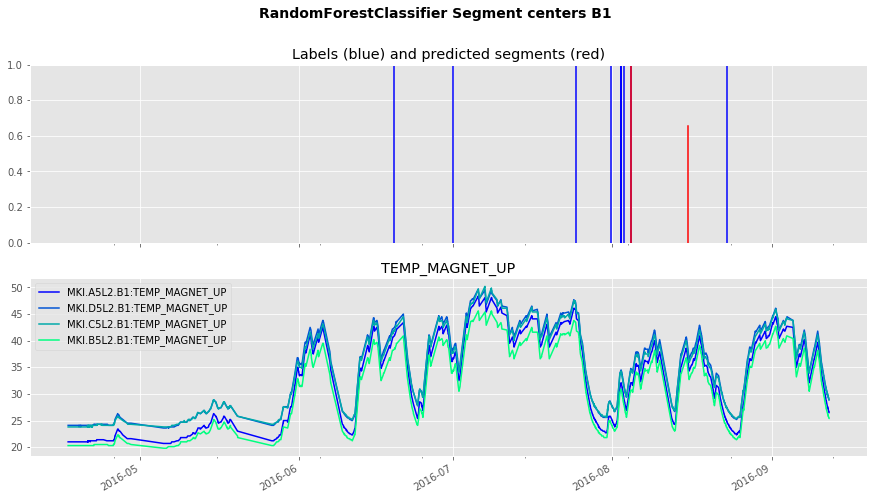

In [19]:
plot.anomalies.timeseries_segments(B1_30, "TEMP_MAGNET_UP", segments, labels_B1, 'RandomForestClassifier Segment centers B1')

Fetching data for pattern MKI.ELOGBOOK_tagged from 2016-04-16 00:00:00.000000 to 2016-09-14 00:00:00.000000
Fetching data for MKI.ELOGBOOK_tagged


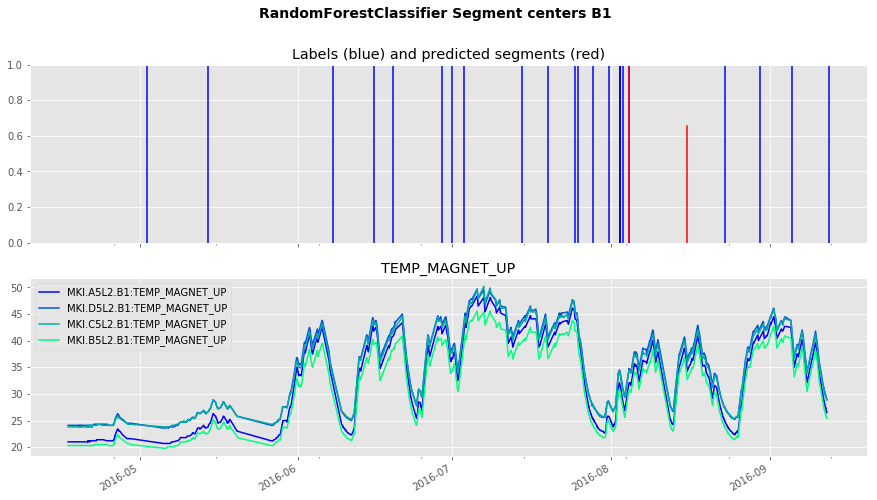

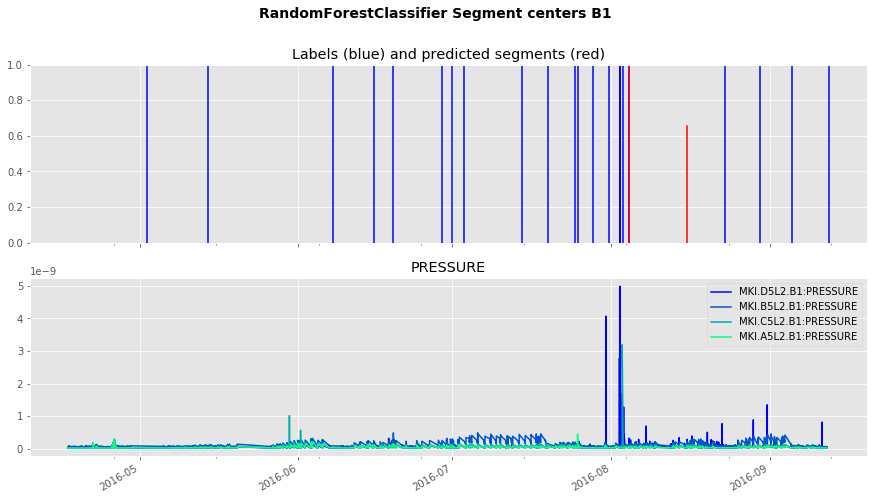

In [22]:
labels_B1_all = db.query_elogbook_no_info(beam=1)
plot.anomalies.timeseries_segments(B1_30, "TEMP_MAGNET_UP", segments, labels_B1_all, 'RandomForestClassifier Segment centers B1')
plot.anomalies.timeseries_segments(B1_30, "PRESSURE", segments, labels_B1_all, 'RandomForestClassifier Segment centers B1')